In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: f'{x:.2f}')


# ML Libraries
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# ML Libraries
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope


# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
df = pd.read_csv('mon_final.csv',index_col=0)#create_realistic_data()
print("=" * 80)

print(f"Dataset shape: {df.shape}")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Months per year:")
for year in sorted(df['year'].unique()):
    months = df[df['year'] == year]['month'].unique()
    print(f"  {year}: {len(months)} months ({', '.join(sorted(months))})")

Dataset shape: (33, 9)
Years available: [np.int64(2023), np.int64(2024), np.int64(2025)]
Months per year:
  2023: 10 months (Apr, Aug, Dec, Jul, Jun, Mar, May, Nov, Oct, Sept)
  2024: 12 months (Apr, Aug, Dec, Feb, Jan, Jul, Jun, Mar, May, Nov, Oct, Sept)
  2025: 11 months (Apr, Aug, Feb, Jan, Jul, Jun, Mar, May, Nov, Oct, Sept)


In [7]:
def create_domain_specific_features(df):
    """
    Create domain-specific features for revenue forecasting with proper handling of:
    1. Monthly vs remaining-months units
    2. No target leakage (using shift(1) for actual_revenue)
    3. Avoiding avg_prob_pct combinations
    """
    df_feat = df.copy()

    # ========== 1. TIME-BASED NORMALIZATION FEATURES ==========
    print("\n1. TIME-BASED NORMALIZATION FEATURES")

    # Month in year (1-12)
    df_feat['month_in_year'] = df_feat['month_num']

    # Remaining months in year (critical for scaling)
    df_feat['remaining_months'] = 13 - df_feat['month_num']

    # Quarter and quarter progress
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['quarter_progress'] = ((df_feat['month_num'] - 1) % 3) / 2

    # Business cycle (based on fiscal patterns)
    df_feat['fiscal_period'] = pd.cut(df_feat['month_num'],
                                      bins=[0, 6, 9, 12],
                                      labels=['H1', 'Q3', 'Q4'])

    # Convert fiscal_period to object to avoid TypeError with fillna(0) later
    df_feat['fiscal_period'] = df_feat['fiscal_period'].astype(object)

    # ========== 2. SCALE-INVARIANT DENSITY FEATURES ==========
    print("2. SCALE-INVARIANT DENSITY FEATURES")

    # Convert remaining-month totals to monthly equivalents
    df_feat['monthly_pipeline_density'] = df_feat['wtd_pipeline_revenue'] / df_feat['remaining_months']
    df_feat['monthly_signed_density'] = df_feat['committed_sign_revenue'] / df_feat['remaining_months']
    df_feat['monthly_unsigned_density'] = df_feat['committed_unsig_revenue'] / df_feat['remaining_months']
    df_feat['monthly_total_committed_density'] = (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue']) / df_feat['remaining_months']

    # Handle division by zero (for December)
    for col in ['monthly_pipeline_density', 'monthly_signed_density',
                'monthly_unsigned_density', 'monthly_total_committed_density']:
        df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # ========== 3. MOMENTUM AND TREND FEATURES ==========
    print("3. MOMENTUM AND TREND FEATURES")

    # Revenue momentum (using shifted actual_revenue to avoid leakage)
    df_feat['revenue_mom_1m'] = df_feat['actual_revenue'].shift(1).pct_change(1)
    df_feat['revenue_mom_3m'] = df_feat['actual_revenue'].shift(1).pct_change(3)
    df_feat['revenue_mom_12m'] = df_feat['actual_revenue'].shift(1).pct_change(12)

    # Signed revenue momentum (density-based, comparable to monthly revenue)
    df_feat['signed_density_mom_1m'] = df_feat['monthly_signed_density'].pct_change(1)
    df_feat['signed_density_mom_3m'] = df_feat['monthly_signed_density'].pct_change(3)

    # Pipeline momentum (density-based)
    df_feat['pipeline_density_mom_1m'] = df_feat['monthly_pipeline_density'].pct_change(1)
    df_feat['pipeline_density_mom_3m'] = df_feat['monthly_pipeline_density'].pct_change(3)

    # ========== 4. CONVERSION AND EFFICIENCY METRICS ==========
    print("4. CONVERSION AND EFFICIENCY METRICS")

    # Historical conversion efficiency (using shifted values)
    df_feat['historical_conversion_rate'] = (
        df_feat['actual_revenue'].shift(1) /
        (df_feat['monthly_signed_density'].shift(1) + 1e-10)
    )

    # Pipeline coverage ratio (using density for comparable units)
    df_feat['pipeline_coverage_ratio'] = (
        df_feat['monthly_pipeline_density'] /
        (df_feat['monthly_signed_density'] + df_feat['monthly_unsigned_density'] + 1e-10)
    )

    # Signed commitment ratio (scale-invariant)
    df_feat['signed_ratio'] = (
        df_feat['committed_sign_revenue'] /
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue'] + 1e-10)
    )

    # ========== 5. SEASONAL AND CYCLICAL PATTERNS ==========
    print("5. SEASONAL AND CYCLICAL PATTERNS")

    # Trigonometric seasonality
    df_feat['seasonal_sin'] = np.sin(2 * np.pi * df_feat['month_num'] / 12)
    df_feat['seasonal_cos'] = np.cos(2 * np.pi * df_feat['month_num'] / 12)

    # Quarter-end effects
    df_feat['is_quarter_end'] = df_feat['month_num'].isin([3, 6, 9, 12]).astype(int)
    df_feat['is_year_end'] = (df_feat['month_num'] == 12).astype(int)

    # ========== 6. BUSINESS HEALTH INDICATORS ==========
    print("6. BUSINESS HEALTH INDICATORS")

    # Run rate analysis
    df_feat['run_rate_3m'] = df_feat['actual_revenue'].shift(1).rolling(3).mean()
    df_feat['required_run_rate'] = df_feat['monthly_total_committed_density']
    df_feat['run_rate_gap'] = df_feat['required_run_rate'] - df_feat['run_rate_3m']
    df_feat['run_rate_gap_pct'] = df_feat['run_rate_gap'] / (df_feat['run_rate_3m'] + 1e-10)

    # Revenue predictability (inverse of volatility)
    df_feat['revenue_volatility_12m'] = (
        df_feat['actual_revenue'].shift(1).rolling(12).std() /
        (df_feat['actual_revenue'].shift(1).rolling(12).mean() + 1e-10)
    )
    df_feat['revenue_predictability'] = 1 / (1 + df_feat['revenue_volatility_12m'])

    # ========== 7. LAG AND ROLLING FEATURES ==========
    print("7. LAG AND ROLLING FEATURES")

    # Lagged actual revenue (properly shifted)
    for lag in [1, 2, 3, 6, 12]:
        df_feat[f'revenue_lag_{lag}'] = df_feat['actual_revenue'].shift(lag)

    # Rolling statistics of actual revenue
    for window in [3, 6, 12]:
        df_feat[f'revenue_rolling_mean_{window}'] = (
            df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).mean()
        )
        df_feat[f'revenue_rolling_std_{window}'] = (
            df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).std()
        )

    # Rolling statistics of signed density
    for window in [3, 6]:
        df_feat[f'signed_density_rolling_mean_{window}'] = (
            df_feat['monthly_signed_density'].rolling(window=window, min_periods=1).mean()
        )

    # ========== 8. INTERACTION FEATURES ==========
    print("8. INTERACTION FEATURES")

    # Time-pressure interaction (more pressure earlier in year)
    df_feat['time_pressure_index'] = df_feat['remaining_months'] * df_feat['monthly_total_committed_density']

    # Seasonality-pressure interaction
    df_feat['seasonal_pressure'] = df_feat['seasonal_sin'] * df_feat['monthly_pipeline_density']

    # Momentum-conversion interaction
    df_feat['momentum_conversion'] = df_feat['signed_density_mom_3m'] * df_feat['historical_conversion_rate']

    # ========== 9. YEAR-OVER-YEAR COMPARISONS ==========
    print("9. YEAR-OVER-YEAR COMPARISONS")

    # YoY growth for revenue
    df_feat['revenue_yoy_growth'] = df_feat['actual_revenue'].shift(1) / df_feat['actual_revenue'].shift(13) - 1

    # YoY growth for signed density
    df_feat['signed_density_yoy_growth'] = (
        df_feat['monthly_signed_density'] / df_feat['monthly_signed_density'].shift(12) - 1
    )

    # Same month comparison
    df_feat['same_month_last_year'] = df_feat.groupby('month_num')['actual_revenue'].shift(12)
    df_feat['same_month_growth'] = df_feat['actual_revenue'] / df_feat['same_month_last_year'] - 1

    # ========== 10. COMPOSITE BUSINESS METRICS ==========
    print("10. COMPOSITE BUSINESS METRICS")

    # Business health score (0-1 scale)
    df_feat['business_health_score'] = (
        0.4 * (df_feat['signed_ratio'].clip(0, 1)) +
        0.3 * (1 - df_feat['revenue_volatility_12m'].clip(0, 1)) +
        0.2 * (df_feat['revenue_mom_3m'].clip(-0.5, 0.5) + 0.5) +
        0.1 * (1 - df_feat['run_rate_gap_pct'].abs().clip(0, 1))
    )

    # Forecast confidence index
    df_feat['forecast_confidence'] = (
        df_feat['revenue_predictability'] *
        (1 + df_feat['signed_ratio']) *
        (1 + df_feat['pipeline_coverage_ratio'].clip(0, 3))
    ) / 3

    # ========== 11. NON-LINEAR TRANSFORMATIONS ==========
    print("11. NON-LINEAR TRANSFORMATIONS")

    # Log transformations for revenue-based features (handle large values)
    for col in ['monthly_signed_density', 'monthly_pipeline_density']:
        df_feat[f'log_{col}'] = np.log1p(df_feat[col])

    df_feat['log_actual_revenue'] = np.log1p(df_feat['actual_revenue'].shift(1))

    # Polynomial terms for key predictors
    df_feat['signed_density_squared'] = df_feat['monthly_signed_density'] ** 2
    df_feat['signed_density_sqrt'] = np.sqrt(df_feat['monthly_signed_density'])

    # Reciprocal for diminishing returns
    df_feat['inv_signed_density'] = 1 / (df_feat['monthly_signed_density'] + 1e-10)

    # ========== 12. TEMPORAL SMOOTHING ==========
    print("12. TEMPORAL SMOOTHING")

    # Exponentially weighted moving averages
    for col in ['monthly_signed_density', 'monthly_pipeline_density']:
        df_feat[f'{col}_ewm_3m'] = df_feat[col].ewm(span=3, min_periods=1).mean()
        df_feat[f'{col}_ewm_6m'] = df_feat[col].ewm(span=6, min_periods=1).mean()

    df_feat['actual_revenue_ewm_6m'] = df_feat['actual_revenue'].shift(1).ewm(span=6, min_periods=1).mean()

    # Clean up infinite values
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.int64]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # Forward fill for temporal features
    df_feat = df_feat.fillna(method='ffill').fillna(0)

    # Count features
    original_cols = set(df.columns)
    new_cols = set(df_feat.columns) - original_cols

    print(f"\nFEATURE ENGINEERING COMPLETE")
    print(f"Original features: {len(original_cols)}")
    print(f"New features created: {len(new_cols)}")
    print(f"Total features: {len(df_feat.columns)}")

    return df_feat

# Create enhanced features
print("Starting advanced feature engineering...")
df_enhanced = create_domain_specific_features(df)
print("Feature engineering completed successfully!")

Starting advanced feature engineering...

1. TIME-BASED NORMALIZATION FEATURES
2. SCALE-INVARIANT DENSITY FEATURES
3. MOMENTUM AND TREND FEATURES
4. CONVERSION AND EFFICIENCY METRICS
5. SEASONAL AND CYCLICAL PATTERNS
6. BUSINESS HEALTH INDICATORS
7. LAG AND ROLLING FEATURES
8. INTERACTION FEATURES
9. YEAR-OVER-YEAR COMPARISONS
10. COMPOSITE BUSINESS METRICS
11. NON-LINEAR TRANSFORMATIONS
12. TEMPORAL SMOOTHING

FEATURE ENGINEERING COMPLETE
Original features: 9
New features created: 62
Total features: 71
Feature engineering completed successfully!


In [9]:
def check_target_leakage(df, target_col='actual_revenue'):
    """Check for potential target leakage in features"""
    leakage_issues = []

    # Check for features using current month's target
    for col in df.columns:
        if target_col in col:
            # Check if it's the actual target column itself
            if col == target_col:
                continue
            # Check if it uses current month (not shifted)
            if not any(x in col for x in ['lag_', 'shift', 'rolling', 'ewm', 'yoy']):
                leakage_issues.append(col)

    # Check correlation with target, only using numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    if target_col not in numeric_df.columns:
        print(f"Warning: Target column '{target_col}' not found in numeric features. Skipping correlation check.")
        high_corr_features = []
    else:
        correlations = numeric_df.corr()[target_col].abs().sort_values(ascending=False)
        high_corr_features = correlations[correlations > 0.9].index.tolist()
        if target_col in high_corr_features:
            high_corr_features.remove(target_col)

    print("\nTARGET LEAKAGE CHECK:")
    print(f"Features potentially using current month target: {leakage_issues}")
    print(f"\nFeatures highly correlated (>0.9) with target: {high_corr_features[:10]}")

    return leakage_issues, high_corr_features

def remove_redundant_features(df, target_col='actual_revenue', correlation_threshold=0.95):
    """Remove highly correlated features while preserving domain-specific ones"""

    # Calculate correlation matrix
    corr_matrix = df.select_dtypes(include=[np.number]).corr().abs()

    # Identify highly correlated features
    redundant_pairs = []
    features_to_consider = [col for col in df.columns if col != target_col and col in corr_matrix.columns]

    for i in range(len(features_to_consider)):
        for j in range(i+1, len(features_to_consider)):
            feat1, feat2 = features_to_consider[i], features_to_consider[j]
            corr_value = corr_matrix.loc[feat1, feat2]

            if corr_value > correlation_threshold:
                redundant_pairs.append((feat1, feat2, corr_value))

    # Domain-specific features to preserve (even if correlated)
    domain_features = [
        'monthly_signed_density', 'monthly_pipeline_density',
        'signed_ratio', 'pipeline_coverage_ratio',
        'revenue_mom_3m', 'signed_density_mom_3m',
        'historical_conversion_rate', 'business_health_score',
        'forecast_confidence', 'run_rate_gap_pct'
    ]

    # Determine which features to remove
    features_to_remove = set()

    for feat1, feat2, corr in redundant_pairs:
        # If both are domain features, keep both
        if feat1 in domain_features and feat2 in domain_features:
            continue

        # Remove the one that's not domain-specific or has lower importance
        if feat1 in domain_features and feat2 not in domain_features:
            features_to_remove.add(feat2)
        elif feat2 in domain_features and feat1 not in domain_features:
            features_to_remove.add(feat1)
        else:
            # Neither is domain-specific, remove the one with 'log_' or 'sqrt_' if present
            if 'log_' in feat1 or 'sqrt_' in feat1:
                features_to_remove.add(feat1)
            elif 'log_' in feat2 or 'sqrt_' in feat2:
                features_to_remove.add(feat2)
            else:
                # Remove the one with higher correlation with target (likely less informative)
                corr1 = abs(df[feat1].corr(df[target_col]))
                corr2 = abs(df[feat2].corr(df[target_col]))
                if corr1 <= corr2:
                    features_to_remove.add(feat1)
                else:
                    features_to_remove.add(feat2)

    print(f"\nREMOVING {len(features_to_remove)} REDUNDANT FEATURES")
    print(f"Features to remove: {list(features_to_remove)[:20]}...")

    # Create filtered dataframe
    features_to_keep = [col for col in df.columns if col not in features_to_remove]
    df_filtered = df[features_to_keep].copy()

    print(f"\nOriginal features: {df.shape[1]}")
    print(f"Filtered features: {df_filtered.shape[1]}")

    return df_filtered

# Check for target leakage
leakage_issues, high_corr = check_target_leakage(df_enhanced)

# Remove redundant features
df_filtered = remove_redundant_features(df_enhanced)



TARGET LEAKAGE CHECK:
Features potentially using current month target: ['log_actual_revenue']

Features highly correlated (>0.9) with target: ['year']

REMOVING 29 REDUNDANT FEATURES
Features to remove: ['momentum_conversion', 'revenue_rolling_mean_12', 'month_num', 'log_monthly_pipeline_density', 'wtd_pipeline_revenue', 'revenue_rolling_mean_6', 'run_rate_gap', 'log_monthly_signed_density', 'is_year_end', 'revenue_volatility_12m', 'monthly_total_committed_density', 'revenue_mom_12m', 'remaining_months', 'run_rate_3m', 'revenue_predictability', 'quarter', 'monthly_signed_density_ewm_3m', 'signed_density_sqrt', 'signed_density_squared', 'monthly_signed_density_ewm_6m']...

Original features: 71
Filtered features: 42


In [11]:
def select_top_features(df, target_col='actual_revenue', n_features=20):
    """Select top features using multiple methods"""

    # Prepare data
    # Filter df for only numeric columns for feature selection methods
    numeric_df = df.select_dtypes(include=np.number).copy()

    # Exclude 'year' and the target column from feature consideration
    feature_cols = [col for col in numeric_df.columns if col != target_col and col != 'year']

    X = numeric_df[feature_cols].fillna(0)
    y = df[target_col].fillna(0)

    # Method 1: Correlation with target
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    top_corr_features = correlations.head(n_features).index.tolist()

    # Method 2: Mutual Information
    from sklearn.feature_selection import mutual_info_regression

    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_series = pd.Series(mi_scores, index=X.columns)
    top_mi_features = mi_series.sort_values(ascending=False).head(n_features).index.tolist()

    # Method 3: Elastic Net feature importance
    from sklearn.linear_model import ElasticNet
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
    elastic_net.fit(X_scaled, y)

    enet_importance = pd.Series(np.abs(elastic_net.coef_), index=X.columns)
    top_enet_features = enet_importance.sort_values(ascending=False).head(n_features).index.tolist()

    # Method 4: Random Forest feature importance
    from sklearn.ensemble import RandomForestRegressor

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
    top_rf_features = rf_importance.sort_values(ascending=False).head(n_features).index.tolist()

    # Combine results using voting
    feature_scores = {}
    for feature in feature_cols:
        scores = []
        if feature in top_corr_features:
            scores.append(4 - top_corr_features.index(feature) * 0.1)
        if feature in top_mi_features:
            scores.append(4 - top_mi_features.index(feature) * 0.1)
        if feature in top_enet_features:
            scores.append(4 - top_enet_features.index(feature) * 0.1)
        if feature in top_rf_features:
            scores.append(4 - top_rf_features.index(feature) * 0.1)

        if scores:
            feature_scores[feature] = np.mean(scores)

    # Get top features
    top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)[:n_features]
    top_features = [feat for feat, score in top_features]

    # Ensure key domain features are included
    key_domain_features = [
        'monthly_signed_density', 'signed_ratio',
        'historical_conversion_rate', 'revenue_mom_3m',
        'business_health_score', 'forecast_confidence'
    ]

    for feat in key_domain_features:
        if feat not in top_features and feat in feature_cols:
            top_features.append(feat)

    # Trim to exactly n_features
    top_features = top_features[:n_features]

    print(f"\nTOP {len(top_features)} FEATURES SELECTED:")
    for i, feat in enumerate(top_features, 1):
        print(f"{i:2}. {feat}")

    return top_features

# Select top 20 features
top_20_features = select_top_features(df_filtered, n_features=20)


TOP 20 FEATURES SELECTED:
 1. revenue_lag_3
 2. signed_density_rolling_mean_6
 3. business_health_score
 4. revenue_lag_1
 5. signed_density_yoy_growth
 6. revenue_lag_6
 7. inv_signed_density
 8. forecast_confidence
 9. revenue_lag_2
10. log_actual_revenue
11. revenue_yoy_growth
12. avg_prob_pct
13. signed_ratio
14. monthly_signed_density
15. monthly_unsigned_density
16. committed_sign_revenue
17. seasonal_cos
18. signed_density_mom_3m
19. historical_conversion_rate
20. revenue_rolling_std_12


In [13]:
def simulate_future_features_enhanced(historical_df, months_to_simulate, feature_columns,
                                      target_month=3, target_year=2025):
    """
    Enhanced simulation function that:
    1. Uses EWMA(6) for ratio/fraction-based features
    2. Uses forward filling for revenue-based features
    3. Adds realistic business patterns
    """

    # Get data up to target month
    data_up_to_may = historical_df[
        (historical_df['year'] < target_year) |
        ((historical_df['year'] == target_year) & (historical_df['month_num'] <= target_month))
    ].copy()

    data_up_to_may = data_up_to_may.sort_values(['year', 'month_num']).reset_index(drop=True)

    # Classify features
    revenue_based_keywords = ['revenue', 'pipeline', 'committed', 'density']
    ratio_based_keywords = ['ratio', 'rate', 'growth', 'momentum', 'confidence', 'health', 'volatility', 'predictability']

    simulated_months = []

    for i in range(1, months_to_simulate + 1):
        month_num = target_month + i
        year = target_year

        if month_num > 12:
            month_num = month_num - 12
            year = target_year + 1

        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        month_name = month_names[month_num - 1]

        new_row = {'year': year, 'month': month_name, 'month_num': month_num}

        for feature in feature_columns:
            # Check feature type
            is_ratio = any(keyword in feature.lower() for keyword in ratio_based_keywords)
            is_revenue = any(keyword in feature.lower() for keyword in revenue_based_keywords) and not is_ratio

            if feature in data_up_to_may.columns:
                feature_values = data_up_to_may[feature].dropna()

                if len(feature_values) == 0:
                    simulated_value = 0
                elif is_ratio:
                    # For ratio features: Use EWMA with trend preservation
                    last_values = feature_values.tail(6).values

                    if len(last_values) < 6:
                        ewma_value = np.mean(last_values)
                    else:
                        # Calculate EWMA with trend adjustment
                        alpha = 2 / (6 + 1)
                        weights = np.array([(1 - alpha) ** (5 - j) for j in range(6)])
                        weights = weights / weights.sum()
                        ewma_value = np.sum(last_values * weights)

                        # Add small random variation (1% of value)
                        variation = np.random.normal(0, abs(ewma_value) * 0.01)
                        ewma_value += variation

                    # Cap ratios between 0 and 1 (for most ratio features)
                    if any(x in feature for x in ['ratio', 'rate']):
                        ewma_value = np.clip(ewma_value, 0, 1)

                    simulated_value = ewma_value

                elif is_revenue:
                    # For revenue-based features: Forward fill with trend
                    last_value = feature_values.iloc[-1]

                    # Calculate recent trend
                    if len(feature_values) >= 3:
                        recent_trend = feature_values.iloc[-1] / feature_values.iloc[-3] - 1
                        trend_factor = 1 + np.clip(recent_trend, -0.1, 0.1)  # Limit trend to ±10%
                    else:
                        trend_factor = 1

                    # Add seasonality
                    if month_num in [12, 1]:  # Year-end/beginning boost
                        seasonality_factor = 1.05
                    elif month_num in [6, 7]:  # Mid-year slowdown
                        seasonality_factor = 0.97
                    else:
                        seasonality_factor = 1.0

                    simulated_value = last_value * trend_factor * seasonality_factor

                else:
                    # For other features: Use EWMA
                    last_values = feature_values.tail(6).values

                    if len(last_values) < 6:
                        simulated_value = np.mean(last_values)
                    else:
                        alpha = 2 / (6 + 1)
                        weights = np.array([(1 - alpha) ** (5 - j) for j in range(6)])
                        weights = weights / weights.sum()
                        simulated_value = np.sum(last_values * weights)
            else:
                simulated_value = 0

            # Add small random noise (0.5% of value)
            noise = np.random.normal(0, abs(simulated_value) * 0.005)
            simulated_value = max(0, simulated_value + noise)

            new_row[feature] = simulated_value

        simulated_months.append(new_row)

        # Add simulated month to historical data for next iteration
        temp_df = pd.DataFrame([new_row])
        data_up_to_may = pd.concat([data_up_to_may, temp_df], ignore_index=True)

    simulated_df = pd.DataFrame(simulated_months)

    # Ensure all feature columns are present
    for col in feature_columns:
        if col not in simulated_df.columns:
            simulated_df[col] = 0

    return simulated_df

# Simulate future months with enhanced method
current_year = 2025
current_month = 3
months_to_simulate = 12 - current_month

# Fix: Re-add 'month_num' to df_filtered if it's missing, as it's required for simulation
# This is a workaround since 'month_num' was removed in a previous step
if 'month_num' not in df_filtered.columns:
    df_filtered_with_month_num = df_filtered.copy()
    df_filtered_with_month_num['month_num'] = df_enhanced['month_num']
else:
    df_filtered_with_month_num = df_filtered


simulated_future = simulate_future_features_enhanced(
    historical_df=df_filtered_with_month_num,
    months_to_simulate=months_to_simulate,
    feature_columns=top_20_features,
    target_month=current_month,
    target_year=current_year
)

print(f"\nSimulated {months_to_simulate} months for top {len(top_20_features)} features")


Simulated 9 months for top 20 features


In [14]:
simulated_future

,year,month,month_num,revenue_lag_3,signed_density_rolling_mean_6,business_health_score,revenue_lag_1,signed_density_yoy_growth,revenue_lag_6,inv_signed_density,...,revenue_yoy_growth,avg_prob_pct,signed_ratio,monthly_signed_density,monthly_unsigned_density,committed_sign_revenue,seasonal_cos,signed_density_mom_3m,historical_conversion_rate,revenue_rolling_std_12
0,2025,Apr,4,161556155.78,156235748.43,0.83,163825894.76,0.35,162484941.37,0.00,...,0.15,1.08,0.88,120411730.25,19203691.11,1145719616.11,0.49,0,1.00,4916442.75
1,2025,May,5,167167391.38,155215335.34,0.83,165259467.99,0.36,169609131.04,0.00,...,0.15,1.09,0.86,109080836.45,17151371.22,1025805811.02,0.49,0,1.00,4438234.84
2,2025,Jun,6,164497275.49,149309653.17,0.80,162243725.93,0.36,174847072.46,0.00,...,0.15,1.10,0.86,94691802.50,14883005.83,904634620.47,0.47,0,1.00,3865159.17
3,2025,Jul,7,163685352.90,138199088.37,0.83,155020276.81,0.37,183187425.85,0.00,...,0.16,1.12,0.86,82658541.45,12944309.61,788808119.15,0.45,0,0.99,3370488.98
4,2025,Aug,8,161100456.73,124684919.21,0.83,144618758.97,0.37,197655188.29,0.00,...,0.16,1.14,0.85,74376101.93,11613569.83,712197511.41,0.43,0,1.00,3038903.00
5,2025,Sept,9,157625463.83,113253867.13,0.84,129280017.86,0.36,217485123.03,0.00,...,0.16,1.17,0.86,66400344.78,10447994.28,644411325.27,0.43,0,0.99,2740232.47
6,2025,Oct,10,150157533.24,102963871.49,0.83,116626709.14,0.36,243052638.91,0.00,...,0.16,1.13,0.86,59660504.56,9402058.00,580600360.26,0.44,0,1.00,2469344.91
7,2025,Nov,11,139088262.95,92467279.31,0.84,104555425.70,0.36,267186022.33,0.00,...,0.16,1.13,0.85,53445041.37,8475711.10,521310132.72,0.44,0,0.99,2210317.60
8,2025,Dec,12,131449583.44,86875962.46,0.84,98436251.64,0.37,309805613.04,0.00,...,0.16,1.14,0.86,49999890.48,8009327.19,489518940.38,0.44,0,0.99,2092609.26


In [19]:
# Prepare training and testing data with optimized features
# Re-add 'month_num' to df_filtered, which was removed during feature reduction.
# This is necessary for indexing and merging operations later in the cell.
if 'month_num' not in df_filtered.columns:
    df_filtered = df_filtered.merge(df_enhanced[['year', 'month', 'month_num']], on=['year', 'month'], how='left')

train_data = df_filtered[df_filtered['year'].isin([2023, 2024])].copy()
test_data_actual = df_filtered[df_filtered['year'] == current_year].copy()

# Combine actual May 2025 with simulated future. Only take features from actual_may_2025 initially.
actual_may_2025_features_only = test_data_actual[test_data_actual['month_num'] == current_month][['year', 'month', 'month_num'] + top_20_features].copy()
test_data_for_features = pd.concat([actual_may_2025_features_only, simulated_future], ignore_index=True)

# Get actual revenues for all relevant 2025 months (May-Nov from df_filtered) and merge them correctly.
actual_revenues_all = test_data_actual[['year', 'month', 'month_num', 'actual_revenue']].copy()

# Merge the actual revenues into the test_data_for_features DataFrame.
# This ensures test_data has a single 'actual_revenue' column correctly.
test_data = pd.merge(
    test_data_for_features,
    actual_revenues_all,
    on=['year', 'month', 'month_num'],
    how='left'
)

print(f"\nTraining data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Scale features
from sklearn.preprocessing import StandardScaler

X_train = train_data[top_20_features]
y_train = train_data['actual_revenue']
X_test = test_data[top_20_features]
y_test = test_data['actual_revenue']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train optimized Elastic Net model
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [10000]
}

elastic_net = ElasticNet(random_state=42)
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")

# Make predictions
y_pred = best_model.predict(X_test_scaled)
test_data['predicted_revenue'] = y_pred

# Calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return {}

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered)),
        'MAE': mean_absolute_error(y_true_filtered, y_pred_filtered),
        'R2': r2_score(y_true_filtered, y_pred_filtered),
        'Max Error': np.max(np.abs(y_true_filtered - y_pred_filtered)),
        'Mean Bias': np.mean(y_pred_filtered - y_true_filtered),
        'Std Error': np.std(y_pred_filtered - y_true_filtered)
    }

    # Directional accuracy
    if len(y_true_filtered) > 1:
        pred_dir = np.sign(np.diff(y_pred_filtered))
        true_dir = np.sign(np.diff(y_true_filtered))
        metrics['Directional Accuracy'] = np.mean(pred_dir == true_dir) * 100

    return metrics

metrics = calculate_metrics(test_data['actual_revenue'].values, test_data['predicted_revenue'].values)

print("\n" + "="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)
for metric, value in metrics.items():
    if metric in ['RMSE', 'MAE', 'Max Error', 'Mean Bias', 'Std Error']:
        print(f"{metric:20}: ${value:,.0f}")
    elif metric in ['R2', 'Directional Accuracy']:
        print(f"{metric:20}: {value:.2%}")
    else:
        print(f"{metric:20}: {value:.2f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': top_20_features,
    'Coefficient': best_model.coef_,
    'Absolute Coefficient': np.abs(best_model.coef_)
})
feature_importance['Importance %'] = (
    feature_importance['Absolute Coefficient'] /
    feature_importance['Absolute Coefficient'].sum() * 100
)
feature_importance = feature_importance.sort_values('Importance %', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print(feature_importance.to_string(index=False))

# Display predictions
print("\n" + "="*80)
print("PREDICTIONS FOR 2025")
print("="*80)
comparison = test_data[['year', 'month', 'month_num', 'actual_revenue', 'predicted_revenue']].copy()
comparison['difference'] = comparison['actual_revenue'] - comparison['predicted_revenue']
comparison['error_pct'] = np.where(
    comparison['actual_revenue'] > 0,
    (comparison['difference'] / comparison['actual_revenue']) * 100,
    np.nan
)

for _, row in comparison.iterrows():
    actual = f"${row['actual_revenue']:,.0f}" if not pd.isna(row['actual_revenue']) else "N/A"
    pred = f"${row['predicted_revenue']:,.0f}"
    diff = f"${row['difference']:,.0f}" if not pd.isna(row['difference']) else "N/A"
    error = f"{row['error_pct']:.1f}%" if not pd.isna(row['error_pct']) else "N/A"

    print(f"{row['month']:6} {row['year']}: Actual: {actual:>15} | Predicted: {pred:>15} | Diff: {diff:>15} | Error: {error:>10}")


Training data shape: (22, 43)
Test data shape: (10, 24)

Best parameters: {'alpha': 1.0, 'l1_ratio': 0.7, 'max_iter': 10000}

MODEL PERFORMANCE METRICS
RMSE                : $14,877,296
MAE                 : $14,099,976
R2                  : -1256.64%
Max Error           : $24,063,779
Mean Bias           : $-14,099,976
Std Error           : $4,746,009
Directional Accuracy: 6250.00%

FEATURE IMPORTANCE ANALYSIS
                      Feature  Coefficient  Absolute Coefficient  Importance %
          forecast_confidence   1805250.10            1805250.10          9.54
        business_health_score   1798397.14            1798397.14          9.50
    signed_density_yoy_growth   1744506.53            1744506.53          9.22
signed_density_rolling_mean_6   1351395.93            1351395.93          7.14
        signed_density_mom_3m  -1289550.13            1289550.13          6.81
                revenue_lag_6   1177921.71            1177921.71          6.22
           log_actual_revenue  -

In [21]:
# Add ensemble modeling for improved performance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit

def create_ensemble_predictions(X_train, y_train, X_test, elastic_net_params):
    """Create ensemble predictions from multiple models"""

    models = {
        'ElasticNet': ElasticNet(random_state=42, **elastic_net_params),
        'Lasso': Lasso(random_state=42, max_iter=10000),
        'Ridge': Ridge(random_state=42)
    }

    predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)

    # Weighted ensemble (more weight to better performing models)
    # Use inverse of cross-validation RMSE as weights
    cv_scores = {}
    tscv = TimeSeriesSplit(n_splits=3)

    for name, model in models.items():
        scores = []
        for train_idx, val_idx in tscv.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        cv_scores[name] = np.mean(scores)

    # Calculate weights (inverse of RMSE)
    weights = {name: 1/(score + 1e-10) for name, score in cv_scores.items()}
    total_weight = sum(weights.values())
    weights = {name: w/total_weight for name, w in weights.items()}

    # Create weighted ensemble prediction
    ensemble_pred = np.zeros_like(predictions['ElasticNet'])
    for name, pred in predictions.items():
        ensemble_pred += pred * weights[name]

    return ensemble_pred, predictions, weights

# Get best ElasticNet parameters from previous GridSearchCV
elastic_net_best_params = grid_search.best_params_

# Get ensemble predictions
ensemble_pred, individual_preds, weights = create_ensemble_predictions(
    X_train_scaled, y_train, X_test_scaled, elastic_net_best_params
)

test_data['ensemble_predicted'] = ensemble_pred

# Calculate ensemble metrics
ensemble_metrics = calculate_metrics(
    test_data['actual_revenue'].values,
    test_data['ensemble_predicted'].values
)

print("\n" + "="*80)
print("ENSEMBLE MODEL PERFORMANCE")
print("="*80)
print(f"Model weights: {weights}")
for metric, value in ensemble_metrics.items():
    if metric in ['RMSE', 'MAE', 'Max Error', 'Mean Bias', 'Std Error']:
        print(f"{metric:20}: ${value:,.0f}")
    elif metric in ['R2', 'Directional Accuracy']:
        print(f"{metric:20}: {value:.2%}")
    else:
        print(f"{metric:20}: {value:.2f}")

# Compare all models
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(f"{'Model':15} {'RMSE':>15} {'MAE':>15} {'R2':>15}")
print("-"*60)

for name, pred in individual_preds.items():
    rmse = np.sqrt(mean_squared_error(y_test.dropna(), pred[~y_test.isna()]))
    mae = mean_absolute_error(y_test.dropna(), pred[~y_test.isna()])
    r2 = r2_score(y_test.dropna(), pred[~y_test.isna()])
    print(f"{name:15} ${rmse:>14,.0f} ${mae:>14,.0f} {r2:>14.3f}")

ensemble_rmse = np.sqrt(mean_squared_error(y_test.dropna(), ensemble_pred[~y_test.isna()]))
ensemble_mae = mean_absolute_error(y_test.dropna(), ensemble_pred[~y_test.isna()])
ensemble_r2 = r2_score(y_test.dropna(), ensemble_pred[~y_test.isna()])
print(f"{'Ensemble':15} ${ensemble_rmse:>14,.0f} ${ensemble_mae:>14,.0f} {ensemble_r2:>14.3f}")


ENSEMBLE MODEL PERFORMANCE
Model weights: {'ElasticNet': np.float64(0.39478289045797593), 'Lasso': np.float64(0.15447237102074612), 'Ridge': np.float64(0.4507447385212779)}
RMSE                : $27,372,492
MAE                 : $23,812,386
R2                  : -4492.47%
Max Error           : $46,019,935
Mean Bias           : $-23,812,386
Std Error           : $13,499,021
Directional Accuracy: 5000.00%

MODEL COMPARISON
Model                      RMSE             MAE              R2
------------------------------------------------------------
ElasticNet      $    14,877,296 $    14,099,976        -12.566
Lasso           $    84,482,003 $    67,122,236       -436.468
Ridge           $    19,969,648 $    17,881,761        -23.443
Ensemble        $    27,372,492 $    23,812,386        -44.925


In [ ]:

# Step 2: Feature Engineering - Create 10 features from the data
def create_engineered_features(data):
    """Create 10 engineered features from the base data"""
    df = data.copy()

    # Sort by year and month for proper rolling calculations
    df = df.sort_values(['year', 'month_num']).reset_index(drop=True)

    # 1. Total committed revenue
    df['total_committed'] = df['committed_unsig_revenue'] + df['committed_sign_revenue']

    # 2. Pipeline to committed ratio
    df['pipeline_to_committed_ratio'] = np.where(
        df['total_committed'] > 0,
        df['wtd_pipeline_revenue'] / df['total_committed'],
        0
    )

    # 3. Pipeline conversion efficiency (probability-adjusted)
    df['pipeline_conversion_efficiency'] = df['wtd_pipeline_revenue'] * df['avg_prob_pct'] / 100

    # 4. Signed vs unsigned ratio
    df['signed_unsigned_ratio'] = np.where(
        df['committed_unsig_revenue'] > 0,
        df['committed_sign_revenue'] / df['committed_unsig_revenue'],
        0
    )

    # 5. Revenue growth rate (MoM)
    df['revenue_growth_rate'] = df['actual_revenue'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # 6. Rolling 3-month average pipeline
    df['rolling_3m_pipeline'] = df['wtd_pipeline_revenue'].rolling(window=3, min_periods=1).mean()

    # 7. Rolling 6-month average committed
    df['rolling_6m_committed'] = df['total_committed'].rolling(window=6, min_periods=1).mean()

    # 8. Pipeline coverage (how many months of revenue is in pipeline)
    #    This feature needs 'actual_revenue' which will not be available for future simulated months.
    #    We will calculate it for historical data and then simulate it or handle separately.
    df['pipeline_coverage_months'] = np.where(
        df['actual_revenue'] > 0, # Only calculate where actual_revenue is known
        df['wtd_pipeline_revenue'] / df['actual_revenue'],
        0
    )

    # 9. Probability-weighted pipeline health
    df['pipeline_health_score'] = (df['wtd_pipeline_revenue'] * df['avg_prob_pct']) / 1000000

    # 10. Quarter-end indicator (Q1: Jan-Mar, Q2: Apr-Jun, Q3: Jul-Sep, Q4: Oct-Dec)
    df['quarter'] = ((df['month_num'] - 1) // 3) + 1

    # 11. Month-over-month pipeline growth
    df['pipeline_growth_rate'] = df['wtd_pipeline_revenue'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # 12. Committed growth rate
    df['committed_growth_rate'] = df['total_committed'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # Fill any NaN values that might have occurred (e.g., from pct_change at start)
    df = df.fillna(0)

    # Select the final 10 features for modeling
    feature_columns = [
        'wtd_pipeline_revenue',
        'total_committed',
        'pipeline_to_committed_ratio',
        'pipeline_conversion_efficiency',
        'signed_unsigned_ratio',
        'rolling_3m_pipeline',
        'rolling_6m_committed',
        'pipeline_coverage_months', # Will need careful simulation
        'pipeline_health_score',    # Will need careful simulation
        'pipeline_growth_rate'
    ]

    return df, feature_columns

# Create engineered features
df_with_features, feature_cols = create_engineered_features(df)
print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETED")
print("=" * 80)
print(f"Created {len(feature_cols)} engineered features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2}. {col}")



FEATURE ENGINEERING COMPLETED
Created 10 engineered features:
 1. wtd_pipeline_revenue
 2. total_committed
 3. pipeline_to_committed_ratio
 4. pipeline_conversion_efficiency
 5. signed_unsigned_ratio
 6. rolling_3m_pipeline
 7. rolling_6m_committed
 8. pipeline_coverage_months
 9. pipeline_health_score
10. pipeline_growth_rate


In [ ]:


def create_advanced_features_fixing_underprediction(df):
    """
    Create  features
    """
    df_feat = df.copy()

    # ========== FOUNDATION: TIME AND BUSINESS CONTEXT ==========
    print("\n 2.1 TIME AND BUSINESS CONTEXT FOUNDATION")

    # Month index and remaining months (CRITICAL for normalization)
    df_feat['remaining_months'] = 13 - df_feat['month_num']
    df_feat['year_progress'] = (df_feat['month_num'] - 1) / 11  # 0 to 1 scale

    # Business quarter
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['quarter_progress'] = ((df_feat['month_num'] - 1) % 3) / 2

    # Business cycle position (based on revenue patterns)
    # Early (Jan-Mar), Middle (Apr-Aug), Late (Sep-Dec)
    df_feat['business_cycle'] = pd.cut(df_feat['month_num'],
                                       bins=[0, 3, 8, 13],
                                       labels=['early', 'middle', 'late'])

    # Convert to numerical
    cycle_map = {'early': 0, 'middle': 1, 'late': 2}
    df_feat['business_cycle_num'] = df_feat['business_cycle'].map(cycle_map)

    print(" Created time and business context features")

    # ========== CRITICAL FIX: SCALE-INVARIANT FEATURES ==========
    print("\n 2.2 SCALE-INVARIANT FEATURES (Fixes distribution shift)")


    forecast_cols = ['wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue']

    # 1. Monthly density (normalized by remaining months)
    for col in forecast_cols:
        df_feat[f'{col}_density'] = df_feat[col] / df_feat['remaining_months']
        # Handle potential infinite values
        df_feat[f'{col}_density'] = df_feat[f'{col}_density'].replace([np.inf, -np.inf], np.nan)

    # 2. Ratio features (scale invariant)
    df_feat['signed_to_total_ratio'] = (
        df_feat['committed_sign_revenue'] /
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue'] + 1e-10)
    )

    df_feat['pipeline_coverage'] = (
        df_feat['wtd_pipeline_revenue'] /
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue'] + 1e-10)
    )

    # 3. Percentage of annual target achieved (YTD perspective)
    df_feat['ytd_actual'] = df_feat.groupby('year')['actual_revenue'].cumsum()
    df_feat['ytd_percentage'] = df_feat['ytd_actual'] / (df_feat['ytd_actual'].max() + 1e-10)

    print("   Created scale-invariant features to handle distribution shift")

    # ========== NON-LINEAR TRANSFORMATIONS ==========
    print("\n 2.3 NON-LINEAR TRANSFORMATIONS (Captures complex relationships)")

    # issues: Linear models can't capture diminishing returns, exponential growth
    # Solution: Add polynomial and logarithmic transformations

    # Log transformations (for multiplicative effects)
    for col in [ 'committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'log_{col}'] = np.log1p(df_feat[col])
        df_feat[f'sqrt_{col}'] = np.sqrt(df_feat[col])

    # for col in ['actual_revenue', 'committed_sign_revenue', 'wtd_pipeline_revenue']:
    #     df_feat[f'log_{col}'] = np.log1p(df_feat[col])
    #     df_feat[f'sqrt_{col}'] = np.sqrt(df_feat[col])

    df_feat['log_actual_revenue_lag_1']=np.log1p(df_feat['actual_revenue'].shift(1))


    # Polynomial terms for key predictors
    for col in ['committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'{col}_squared'] = df_feat[col] ** 2
        df_feat[f'{col}_cubed'] = df_feat[col] ** 3
        df_feat[f'{col}_log_squared'] = np.log1p(df_feat[col]) ** 2

    # Reciprocal transformations (for diminishing returns)
    df_feat['inv_pipeline'] = 1 / (df_feat['wtd_pipeline_revenue'] + 1e-10)
    df_feat['inv_signed'] = 1 / (df_feat['committed_sign_revenue'] + 1e-10)


    print("   Added non-linear transformations")

    # ========== BUSINESS MOMENTUM METRICS ==========
    print("\n 2.4 BUSINESS MOMENTUM METRICS (Captures acceleration)")

    # REASONING: Underprediction often misses acceleration/deceleration
    # Solution: Add velocity and acceleration terms

    # Revenue momentum (1st derivative)
    df_feat['revenue_growth_1m'] = df_feat['actual_revenue'].pct_change(1)
    df_feat['revenue_growth_3m'] = df_feat['actual_revenue'].pct_change(3)
    df_feat['revenue_growth_12m'] = df_feat['actual_revenue'].pct_change(12)

    # Pipeline momentum
    df_feat['pipeline_growth_1m'] = df_feat['committed_sign_revenue'].pct_change(1)
    df_feat['pipeline_growth_3m'] = df_feat['committed_sign_revenue'].pct_change(3)

    # Acceleration (2nd derivative)
    df_feat['revenue_acceleration'] = df_feat['revenue_growth_1m'].diff(1)
    df_feat['pipeline_acceleration'] = df_feat['pipeline_growth_1m'].diff(1)

    # Momentum strength
    df_feat['momentum_strength'] = (
        df_feat['revenue_growth_3m'].abs() * df_feat['pipeline_growth_3m'].abs()
    )

    print("  Created business momentum metrics")

    # ========== INTERACTION FEATURES ==========
    print("\n 2.5 INTERACTION FEATURES (Captures combined effects)")

    # issues : Combined effect of multiple factors > sum of parts
    # Solution: Multiply key variables

    # 1. Pipeline pressure (size × time pressure)
    df_feat['pipeline_pressure'] = (
        df_feat['committed_sign_revenue_density'] *
        (12 - df_feat['month_num'])
    )

    # 2. Conversion urgency (signed ratio × time remaining)
    df_feat['conversion_urgency'] = (
        df_feat['signed_to_total_ratio'] *
        df_feat['remaining_months']
    )

    # 3. Business efficiency (revenue per pipeline)
    df_feat['business_efficiency'] = (
        df_feat['actual_revenue'] /
        (df_feat['wtd_pipeline_revenue'] + 1e-10)
    )

    # 4. Growth-pressure interaction
    df_feat['growth_pressure'] = (
        df_feat['revenue_growth_3m'] *
        df_feat['pipeline_pressure']
    )

    # 5. Seasonality-pressure interaction
    df_feat['seasonal_pressure'] = (
        np.sin(2 * np.pi * df_feat['month_num'] / 12) *
        df_feat['pipeline_pressure']
    )

    print("   Created interaction features")

    # ========== TEMPORAL FEATURES WITH GUIDELINES ==========
    print("\n 2.6 TEMPORAL FEATURES (Following guidelines)")

    # issues: Need to capture time dependencies without leakage
    # Solution: Use EMW and proper lag structures as per guidelines

    # 6-month EMW as per guidelines
    for col in ['actual_revenue', 'committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'{col}_ewm_6m'] = df_feat[col].ewm(span=6, min_periods=1).mean()
        df_feat[f'{col}_ewm_3m'] = df_feat[col].ewm(span=3, min_periods=1).mean()

    # Lag features with proper shifting (avoiding target leakage)
    lags = [1, 2, 3, 6, 12]
    for lag in lags:
        df_feat[f'revenue_lag_{lag}'] = df_feat['actual_revenue'].shift(lag)
        df_feat[f'pipeline_lag_{lag}'] = df_feat['committed_sign_revenue'].shift(lag)

    # Rolling statistics (using shift to avoid leakage)
    windows = [3, 6, 12]
    for window in windows:
        df_feat[f'revenue_rolling_mean_{window}'] = (
            df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).mean()
        )
        df_feat[f'revenue_rolling_std_{window}'] = (
            df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).std()
        )

    print("   Created temporal features following guidelines")

    # ========== BUSINESS INTELLIGENCE METRICS ==========
    print("\n 2.7 BUSINESS INTELLIGENCE METRICS (Domain knowledge)")

    # REASONING: Incorporate business rules and heuristics

    # 1. Run rate analysis
    df_feat['monthly_run_rate'] = df_feat['actual_revenue'].rolling(3).mean()
    df_feat['required_run_rate'] = (
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue']) /
        df_feat['remaining_months']
    )
    df_feat['run_rate_gap'] = df_feat['required_run_rate'] - df_feat['monthly_run_rate']
    df_feat['run_rate_gap_pct'] = df_feat['run_rate_gap'] / (df_feat['monthly_run_rate'] + 1e-10)

    # 2. Forecast confidence (using avg_prob_pct as guidance)
    df_feat['forecast_confidence'] = (
        df_feat['avg_prob_pct'] /
        df_feat['avg_prob_pct'].rolling(12, min_periods=1).mean()
    )

    # 3. Pipeline conversion efficiency
    df_feat['conversion_efficiency'] = (
        df_feat['actual_revenue'].shift(1) /
        (df_feat['wtd_pipeline_revenue'].shift(1) + 1e-10)
    ).rolling(6, min_periods=1).mean()

    # 4. Business health score (composite metric)
    df_feat['business_health'] = (
        0.4 * (df_feat['revenue_growth_3m'].clip(-0.5, 0.5) + 0.5) +  # Normalized to 0-1
        0.3 * df_feat['signed_to_total_ratio'] +
        0.2 * df_feat['forecast_confidence'].clip(0, 2) / 2 +
        0.1 * (1 - df_feat['run_rate_gap_pct'].clip(-1, 1).abs())
    )

    print("  Created business intelligence metrics")

    # ========== YEAR-OVER-YEAR FEATURES ==========
    print("\n 2.8 YEAR-OVER-YEAR FEATURES (Addresses distribution shift)")

    # issues: 2025 values different from 2023-2024
    # Solution: Compare with same period in previous years

    # YoY growth for key metrics
    for col in ['actual_revenue', 'committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'{col}_yoy'] = df_feat[col] / df_feat[col].shift(12)
        df_feat[f'{col}_yoy_growth'] = df_feat[f'{col}_yoy'] - 1

    # Same month comparison
    df_feat['same_month_last_year'] = df_feat.groupby('month_num')['actual_revenue'].shift(12)
    df_feat['same_month_growth'] = (
        df_feat['actual_revenue'] / df_feat['same_month_last_year'] - 1
    )

    # YTD comparison
    df_feat['ytd_last_year'] = df_feat.groupby('month_num')['ytd_actual'].shift(12)
    df_feat['ytd_growth'] = df_feat['ytd_actual'] / df_feat['ytd_last_year'] - 1

    print("  Created year-over-year features to normalize across years")

    # ========== COMPOUND AND DERIVED FEATURES ==========
    print("\n 2.9 COMPOUND AND DERIVED FEATURES (Higher-order insights)")

    # REASONING: Complex patterns require higher-order features

    # 1. Revenue predictability
    df_feat['revenue_predictability'] = 1 / (
        1 + df_feat['actual_revenue'].rolling(12).std() /
        df_feat['actual_revenue'].rolling(12).mean()
    )

    # 2. Forecast reliability index
    df_feat['forecast_reliability'] = (
        df_feat['committed_sign_revenue'].pct_change().abs().rolling(3).mean() *
        df_feat['forecast_confidence']
    )

    # 3. Business momentum index
    df_feat['business_momentum_index'] = (
        df_feat['revenue_growth_3m'].clip(0, 1) *
        df_feat['pipeline_growth_3m'].clip(0, 1) *
        df_feat['business_health']
    )

    # 4. Time-adjusted pipeline value
    df_feat['time_adjusted_pipeline'] = (
        df_feat['committed_sign_revenue'] *
        np.exp(-0.1 * (12 - df_feat['month_num']))  # Exponential decay
    )

    print("   Created compound features for higher-order insights")

    # ========== VALIDATION AND CLEANUP ==========
    print("\n 2.10 FEATURE VALIDATION AND CLEANUP")

    # Remove infinite values
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.int64]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # Count features created
    original_cols = set(df.columns)
    new_cols = set(df_feat.columns) - original_cols

    print(f"\n FEATURE ENGINEERING SUMMARY:")
    print(f"  Original features: {len(original_cols)}")
    print(f"  New features created: {len(new_cols)}")
    print(f"  Total features: {len(df_feat.columns)}")

    # Categorize features
    feature_categories = {
        'Time Context': [col for col in new_cols if any(x in col for x in ['month', 'quarter', 'cycle', 'progress'])],
        'Scale-Invariant': [col for col in new_cols if any(x in col for x in ['ratio', 'density', 'percentage', 'coverage'])],
        'Non-Linear': [col for col in new_cols if any(x in col for x in ['log_', 'sqrt_', '_squared', '_cubed', 'inv_'])],
        'Momentum': [col for col in new_cols if any(x in col for x in ['growth', 'acceleration', 'momentum'])],
        'Interactions': [col for col in new_cols if any(x in col for x in ['pressure', 'urgency', 'efficiency', 'interaction'])],
        'Temporal': [col for col in new_cols if any(x in col for x in ['lag_', 'ewm_', 'rolling_', 'shift'])],
        'Business Metrics': [col for col in new_cols if any(x in col for x in ['run_rate', 'confidence', 'health', 'predictability'])],
        'YoY Features': [col for col in new_cols if any(x in col for x in ['yoy', 'same_month', 'ytd_'])],
        'Compound': [col for col in new_cols if any(x in col for x in ['index', 'adjusted', 'reliability'])]
    }

    print("\n Feature Categories Created:")
    for category, features in feature_categories.items():
        if features:
            print(f"  {category}: {len(features)} features")

    # Sample important features
    print("\n SAMPLE OF KEY FEATURES CREATED:")
    key_features = [
        'committed_sign_revenue_density',  # Scale-invariant
        'signed_to_total_ratio',           # Ratio
        'log_committed_sign_revenue',      # Non-linear
        'revenue_growth_3m',               # Momentum
        'pipeline_pressure',               # Interaction
        'committed_sign_revenue_ewm_6m',   # Temporal (guideline)
        'run_rate_gap_pct',                # Business metric
        'committed_sign_revenue_yoy',      # YoY normalization
        'business_health',                 # Compound metric
        'time_adjusted_pipeline'           # Time-weighted
    ]

    for feat in key_features:
        if feat in df_feat.columns:
            print(f"  ✓ {feat}")

    return df_feat, df_feat.columns

# Create advanced features
print("\n Starting advanced feature engineering...")
df_features,all_columns = create_advanced_features_fixing_underprediction(df)

print(" Advanced features created")


 Starting advanced feature engineering...

 2.1 TIME AND BUSINESS CONTEXT FOUNDATION
 Created time and business context features

 2.2 SCALE-INVARIANT FEATURES (Fixes distribution shift)
   Created scale-invariant features to handle distribution shift

 2.3 NON-LINEAR TRANSFORMATIONS (Captures complex relationships)
   Added non-linear transformations

 2.4 BUSINESS MOMENTUM METRICS (Captures acceleration)
  Created business momentum metrics

 2.5 INTERACTION FEATURES (Captures combined effects)
   Created interaction features

 2.6 TEMPORAL FEATURES (Following guidelines)
   Created temporal features following guidelines

 2.7 BUSINESS INTELLIGENCE METRICS (Domain knowledge)
  Created business intelligence metrics

 2.8 YEAR-OVER-YEAR FEATURES (Addresses distribution shift)
  Created year-over-year features to normalize across years

 2.9 COMPOUND AND DERIVED FEATURES (Higher-order insights)
   Created compound features for higher-order insights

 2.10 FEATURE VALIDATION AND CLEANUP


In [ ]:
all_columns

Index(['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue',
       'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct',
       'date', 'remaining_months', 'year_progress', 'quarter',
       'quarter_progress', 'business_cycle', 'business_cycle_num',
       'wtd_pipeline_revenue_density', 'committed_unsig_revenue_density',
       'committed_sign_revenue_density', 'signed_to_total_ratio',
       'pipeline_coverage', 'ytd_actual', 'ytd_percentage',
       'log_committed_sign_revenue', 'sqrt_committed_sign_revenue',
       'log_wtd_pipeline_revenue', 'sqrt_wtd_pipeline_revenue',
       'log_actual_revenue_lag_1', 'committed_sign_revenue_squared',
       'committed_sign_revenue_cubed', 'committed_sign_revenue_log_squared',
       'wtd_pipeline_revenue_squared', 'wtd_pipeline_revenue_cubed',
       'wtd_pipeline_revenue_log_squared', 'inv_pipeline', 'inv_signed',
       'revenue_growth_1m', 'revenue_growth_3m', 'revenue_growth_12m',
       'pipeline_growth_

In [ ]:
import re

feature_lines = """
   1. revenue_rolling_mean_3                   (score: 0.865)
   2. revenue_lag_3                            (score: 0.647)
   3. revenue_growth_12m                       (score: 0.555)
   4. revenue_lag_6                            (score: 0.504)
   5. avg_prob_pct                             (score: 0.472)
   6. revenue_lag_12                           (score: 0.463)
   7. wtd_pipeline_revenue_yoy_growth          (score: 0.388)
   8. committed_sign_revenue_yoy_growth        (score: 0.361)
   9. wtd_pipeline_revenue_ewm_6m              (score: 0.355)
  10. revenue_rolling_std_6                    (score: 0.294)
  11. run_rate_gap_pct                         (score: 0.237)
  12. forecast_confidence                      (score: 0.225)
  13. revenue_growth_1m                        (score: 0.216)
  14. revenue_predictability                   (score: 0.200)
  15. forecast_reliability                     (score: 0.160)
  16. revenue_growth_3m                        (score: 0.157)
  17. required_run_rate                        (score: 0.157)
  18. business_health                          (score: 0.153)
  19. conversion_urgency                       (score: 0.150)
  20. pipeline_pressure                        (score: 0.145)
  21. committed_sign_revenue_density           (score: 0.118)
  22. revenue_rolling_std_12                   (score: 0.100)
  23. committed_sign_revenue_ewm_6m            (score: 0.088)
  24. quarter_progress                         (score: 0.079)
  25. seasonal_pressure
"""

selected_features = []
for line in feature_lines.strip().split('\n'):
    if re.match(r'^\s*\d+\.', line): # Check if line starts with a number and dot, followed by space
        # Remove the leading number and dot
        feature_name = re.sub(r'^\s*\d+\.\s*', '', line).strip()
        # Remove score in parenthesis if present
        feature_name = re.split(r'\s+\(score:', feature_name)[0].strip()
        selected_features.append(feature_name)



In [ ]:
selected_features

['revenue_rolling_mean_3',
 'revenue_lag_3',
 'revenue_growth_12m',
 'revenue_lag_6',
 'avg_prob_pct',
 'revenue_lag_12',
 'wtd_pipeline_revenue_yoy_growth',
 'committed_sign_revenue_yoy_growth',
 'wtd_pipeline_revenue_ewm_6m',
 'revenue_rolling_std_6',
 'run_rate_gap_pct',
 'forecast_confidence',
 'revenue_growth_1m',
 'revenue_predictability',
 'forecast_reliability',
 'revenue_growth_3m',
 'required_run_rate',
 'business_health',
 'conversion_urgency',
 'pipeline_pressure',
 'committed_sign_revenue_density',
 'revenue_rolling_std_12',
 'committed_sign_revenue_ewm_6m',
 'quarter_progress',
 'seasonal_pressure']

In [ ]:
numeric_cols = df_features.select_dtypes(include=['number']).columns

df_features[numeric_cols] = df_features[numeric_cols].fillna(df_features[numeric_cols].mean())

In [ ]:
lst=['month','date','business_cycle','business_cycle_num']
fin_feat=[feat for feat in selected_features]+['year','month_num','month'] + ['actual_revenue']
df_with_features=df_features[fin_feat]
df_with_features

,revenue_rolling_mean_3,revenue_lag_3,revenue_growth_12m,revenue_lag_6,avg_prob_pct,revenue_lag_12,wtd_pipeline_revenue_yoy_growth,committed_sign_revenue_yoy_growth,wtd_pipeline_revenue_ewm_6m,revenue_rolling_std_6,...,pipeline_pressure,committed_sign_revenue_density,revenue_rolling_std_12,committed_sign_revenue_ewm_6m,quarter_progress,seasonal_pressure,year,month_num,month,actual_revenue
0,153125227.66,152662741.52,0.14,150229839.67,1.08,145239520.66,0.02,0.23,149498941.00,5654341.56,...,803099767.41,89233307.49,7495357.66,892333074.90,1.00,803099767.41,2023,3,Mar,143652715.00
1,143652715.00,152662741.52,0.14,150229839.67,0.30,145239520.66,0.02,0.23,136970243.47,5654341.56,...,752346161.42,94043270.18,7495357.66,865532616.31,0.00,651550888.23,2023,4,Apr,124885992.10
2,134269353.55,152662741.52,0.14,150229839.67,0.32,145239520.66,0.02,0.23,125377889.83,13270077.02,...,694996890.00,99285270.00,13270077.02,833502594.67,0.50,347498445.00,2023,5,May,138875729.00
3,135804812.03,143652715.00,0.14,150229839.67,0.23,145239520.66,0.02,0.23,116251051.76,9752967.26,...,581444732.14,96907455.36,9752967.26,773574002.71,1.00,0.00,2023,6,Jun,141234442.90
4,134998721.33,124885992.10,0.14,150229839.67,0.24,145239520.66,0.02,0.23,100026263.59,8413311.07,...,499266942.83,99853388.57,8413311.07,712345634.81,0.00,-249633471.42,2023,7,Jul,129631650.00
5,136580607.30,138875729.00,0.14,150229839.67,0.23,145239520.66,0.02,0.23,84684302.23,8026814.34,...,431899459.20,107974864.80,8026814.34,655521253.86,0.50,-374035903.55,2023,8,Aug,136786674.90
6,135884255.93,141234442.90,0.14,143652715.00,0.20,145239520.66,0.02,0.23,68332444.81,7194221.98,...,332991499.27,110997166.42,7194221.98,588749060.37,1.00,-332991499.27,2023,9,Sept,144552454.10
7,136990259.67,129631650.00,0.14,124885992.10,0.19,145239520.66,0.02,0.23,51962875.52,7396072.06,...,225526464.67,112763232.33,7345967.93,511987876.71,0.00,-195311647.63,2023,10,Oct,134711395.80
8,138683508.27,136786674.90,0.14,138875729.00,0.17,145239520.66,0.02,0.23,38585444.75,5208977.73,...,118818508.50,118818508.50,6852776.90,429615050.74,0.50,-59409254.25,2023,11,Nov,139183383.30
9,139482411.07,144552454.10,0.14,141234442.90,0.11,145239520.66,0.02,0.23,28833197.45,5225157.66,...,0.00,209692686.90,6459583.86,364529994.26,1.00,-0.00,2023,12,Dec,140163210.50


In [ ]:
feature_cols = selected_features

In [ ]:

# Step 3: Prepare data for simulation
current_year = 2025
current_month = 3  # March 2025

# All historical data available for simulation (2023, 2024, 2025 Jan-March)
historical_data = df_with_features.copy()
print(f"\nHistorical data shape (all years): {historical_data.shape}")


Historical data shape (all years): (33, 28)


In [ ]:
historical_data.columns

Index(['revenue_rolling_mean_3', 'revenue_lag_3', 'revenue_growth_12m',
       'revenue_lag_6', 'avg_prob_pct', 'revenue_lag_12',
       'wtd_pipeline_revenue_yoy_growth', 'committed_sign_revenue_yoy_growth',
       'wtd_pipeline_revenue_ewm_6m', 'revenue_rolling_std_6',
       'run_rate_gap_pct', 'forecast_confidence', 'revenue_growth_1m',
       'revenue_predictability', 'forecast_reliability', 'revenue_growth_3m',
       'required_run_rate', 'business_health', 'conversion_urgency',
       'pipeline_pressure', 'committed_sign_revenue_density',
       'revenue_rolling_std_12', 'committed_sign_revenue_ewm_6m',
       'quarter_progress', 'seasonal_pressure', 'year', 'month_num', 'month'],
      dtype='object')

In [ ]:
# Step 4: Simulation of future months (apr-Dec 2025) using EWMA(6)
def simulate_future_months_emw6(historical_df, months_to_simulate, feature_columns,
                                target_month=3, target_year=2025):
    """
    Simulate features for future months using EWMA(6) on historical data
    Includes 2023, 2024, and 2025 Jan-May to simulate Jun-Dec 2025
    """
    # Get all data up to May 2025
    data_up_to_may = historical_df[
        (historical_df['year'] < target_year) |
        ((historical_df['year'] == target_year) & (historical_df['month_num'] <= target_month))
    ].copy()

    # Sort chronologically
    data_up_to_may = data_up_to_may.sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_months = []

    # For each month to simulate (June to December 2025)
    for i in range(1, months_to_simulate + 1):
        month_num = target_month + i
        year = target_year

        if month_num > 12:
            month_num = month_num - 12
            year = target_year + 1

        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        month_name = month_names[month_num - 1]

        # Create base record for this month
        new_row = {
            'year': year,
            'month': month_name,
            'month_num': month_num,
        }

        # For each feature, calculate EWMA(6) using the last 6 available values
        for feature in feature_columns:
            # Get the last 6 values of this feature
            # For EWMA, only non-NaN values should be used from the combined data to avoid errors.
            feature_values = data_up_to_may[feature].dropna().tail(6).values

            if len(feature_values) == 0: # If no historical data for feature, default to 0 or mean of training data
                ewma_value = 0 # Or a more sophisticated default
            elif len(feature_values) < 6:
                ewma_value = np.mean(feature_values)
            else:
                # Calculate EWMA weights (alpha = 2/(N+1) where N=6)
                alpha = 2 / (6 + 1)
                weights = np.array([(1 - alpha) ** (5 - j) for j in range(6)])
                weights = weights / weights.sum()

                # Calculate EWMA
                ewma_value = np.sum(feature_values * weights)

            # Add small random variation (2% of value)
            variation = np.random.normal(0, ewma_value * 0.02)
            simulated_value = max(0, ewma_value + variation)

            # Apply seasonality adjustment based on month
            if month_num in [12, 1, 2]:  # Winter months
                simulated_value = simulated_value * 0.95
            elif month_num in [6, 7, 8]:  # Summer months
                simulated_value = simulated_value * 1.05

            new_row[feature] = simulated_value

        # Add to simulated months
        simulated_months.append(new_row)

        # Add this simulated month to data_up_to_may for next iteration's EWMA calculation
        # (so June simulation affects July, etc.)
        temp_df = pd.DataFrame([new_row])
        data_up_to_may = pd.concat([data_up_to_may, temp_df], ignore_index=True)

    simulated_df = pd.DataFrame(simulated_months)

    # Ensure all feature columns are present
    for col in feature_columns:
        if col not in simulated_df.columns:
            simulated_df[col] = 0 # Default for missing simulated features

    return simulated_df

# Simulate June to December 2025 (7 months)
months_to_simulate = 12 - current_month  # June(6) to December(12) = 7 months
simulated_future = simulate_future_months_emw6(
    historical_df=df_with_features, # Pass all historical data with engineered features
    months_to_simulate=months_to_simulate,
    feature_columns=feature_cols,
    target_month=current_month,
    target_year=current_year
)

print("\n" + "=" * 80)
print("FUTURE MONTHS SIMULATION COMPLETED")
print("=" * 80)
print(f"Simulated {months_to_simulate} Months :")
print(simulated_future[['year', 'month', 'month_num'] + feature_cols[:5]].to_string(index=False))


FUTURE MONTHS SIMULATION COMPLETED
Simulated 9 Months :
 year month  month_num  revenue_rolling_mean_3  revenue_lag_3  revenue_growth_12m  revenue_lag_6  avg_prob_pct
 2025   Apr          4            160276281.79   159274349.38                0.14   155308658.23          1.08
 2025   May          5            156043881.21   157985199.85                0.14   156956125.09          1.10
 2025   Jun          6            160822097.55   163958017.22                0.15   165651727.19          1.18
 2025   Jul          7            166016887.59   166355903.19                0.16   165678507.15          1.21
 2025   Aug          8            171871574.04   166308827.97                0.16   167405556.80          1.24
 2025  Sept          9            164362855.90   167666488.50                0.16   162346783.10          1.23
 2025   Oct         10            160932309.77   161350382.85                0.15   167120525.24          1.23
 2025   Nov         11            162841296.35   163709

In [ ]:

# Step 5: Combine actual May 2025 data with simulated future data for test set
# Get actual May 2025 data (features + temporal columns)
actual_may_2025_features = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] == current_month)
][feature_cols + ['year', 'month', 'month_num']].copy()

# Create test dataset with features (May actual features, Jun-Dec simulated features)
# This DataFrame will contain features and temporal info for May-Dec.
# 'actual_revenue' will NOT be in this df yet, but will be merged in.
test_data_features_combined = pd.concat([actual_may_2025_features, simulated_future[feature_cols + ['year', 'month', 'month_num']]],
                                        ignore_index=True)

# Get actual revenue for all relevant 2025 months (May-Nov from df_with_features)
test_actual_revenues_all = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] >= current_month)
][['year', 'month', 'month_num', 'actual_revenue']].copy()

# Merge the actual revenues into the test_data_features_combined DataFrame.
# This ensures test_data has a single 'actual_revenue' column correctly.
test_data = pd.merge(
    test_data_features_combined,
    test_actual_revenues_all,
    on=['year', 'month', 'month_num'],
    how='left'
)

print("\n" + "=" * 80)
print("TEST DATASET PREPARED")
print("=" * 80)
print(f"Test dataset includes: March 2025 (actual) + Jun-Dec 2025 (simulated)")
print(f"Test data shape: {test_data.shape}")


TEST DATASET PREPARED
Test dataset includes: March 2025 (actual) + Jun-Dec 2025 (simulated)
Test data shape: (10, 29)


In [ ]:
test_data

,revenue_rolling_mean_3,revenue_lag_3,revenue_growth_12m,revenue_lag_6,avg_prob_pct,revenue_lag_12,wtd_pipeline_revenue_yoy_growth,committed_sign_revenue_yoy_growth,wtd_pipeline_revenue_ewm_6m,revenue_rolling_std_6,...,pipeline_pressure,committed_sign_revenue_density,revenue_rolling_std_12,committed_sign_revenue_ewm_6m,quarter_progress,seasonal_pressure,year,month,month_num,actual_revenue
0,162371113.20,162019263.80,0.13,159575413.30,2.15,155459389.30,0.22,0.32,148802553.77,2266606.57,...,1163200621.50,129244513.50,5495269.02,1072877525.64,1.00,1163200621.50,2025,Mar,3,175925227.90
1,160276281.79,159274349.38,0.14,155308658.23,1.08,139567078.18,0.24,0.35,110855906.02,3021083.68,...,993474702.04,149976407.79,6853222.62,873356193.43,0.62,764733163.70,2025,Apr,4,170681266.00
2,156043881.21,157985199.85,0.14,156956125.09,1.10,149483782.87,0.25,0.36,116016752.40,2726176.10,...,983713401.18,147220751.53,6801075.57,873884730.70,0.65,819553050.72,2025,May,5,172455903.80
3,160822097.55,163958017.22,0.15,165651727.19,1.18,148712704.10,0.27,0.38,124874204.98,2868924.95,...,1088994297.39,153840140.75,7093634.95,945721392.58,0.66,932689135.99,2025,Jun,6,171322481.00
4,166016887.59,166355903.19,0.16,165678507.15,1.21,154072021.06,0.28,0.40,126961099.16,2826851.34,...,1187235959.06,148599783.46,7067086.94,986158189.62,0.67,973967168.76,2025,Jul,7,178908145.60
5,171871574.04,166308827.97,0.16,167405556.80,1.24,156891656.86,0.26,0.40,127905600.73,2921268.64,...,1169027812.05,152003604.42,7285536.39,1012121857.70,0.70,976845242.25,2025,Aug,8,173445947.90
6,164362855.90,167666488.50,0.16,162346783.10,1.23,150866906.98,0.27,0.38,119274982.17,2788766.37,...,1129263293.86,149598442.88,7193717.31,968447001.20,0.67,931667206.62,2025,Sept,9,177238137.10
7,160932309.77,161350382.85,0.15,167120525.24,1.23,155005461.06,0.27,0.39,120088462.91,2859247.79,...,1074371989.48,151485362.83,7050100.50,964681252.97,0.67,967517832.81,2025,Oct,10,184324060.90
8,162841296.35,163709164.02,0.15,168041244.86,1.20,154298472.85,0.27,0.38,121462034.96,2903018.88,...,1118533928.81,158929811.87,7332063.42,954187015.25,0.68,945526034.08,2025,Nov,11,175457714.90
9,158457601.35,160552170.89,0.15,154526030.99,1.12,150863729.55,0.25,0.35,116678950.13,2762879.12,...,1034803144.59,142708699.31,6718620.43,911381985.18,0.63,877819693.53,2025,Dec,12,NaN


In [ ]:
# Step 6: Prepare training data (2023 and 2024)
train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()

print(f"\nTraining data (2023-2024): {train_data.shape[0]} rows")
print(f"Test data (2025 May-Dec): {test_data.shape[0]} rows")

# Step 7: Scale the features
target_col = 'actual_revenue'

# Prepare feature matrices
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "=" * 80)
print("FEATURE SCALING COMPLETED")
print("=" * 80)
print(f"Training data scaled shape: {X_train_scaled.shape}")
print(f"Test data scaled shape: {X_test_scaled.shape}")



Training data (2023-2024): 22 rows
Test data (2025 May-Dec): 10 rows

FEATURE SCALING COMPLETED
Training data scaled shape: (22, 25)
Test data scaled shape: (10, 25)


In [ ]:

# Step 8: Train Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

print("\n" + "=" * 80)
print("ELASTIC NET MODEL TRAINED")
print("=" * 80)
print("Model Coefficients:")
for feature, coef in zip(feature_cols, elastic_net.coef_):
    print(f"  {feature:30}: {coef:12.4f}")
print(f"Intercept: {elastic_net.intercept_:.2f}")

# Step 9: Make predictions
y_pred = elastic_net.predict(X_test_scaled)

# Add predictions to test data
test_data['predicted_revenue'] = y_pred

print("\n" + "=" * 80)
print("PREDICTIONS COMPLETED")
print("=" * 80)



ELASTIC NET MODEL TRAINED
Model Coefficients:
  revenue_rolling_mean_3        : 3120835.0501
  revenue_lag_3                 :  280776.5217
  revenue_growth_12m            : 1059630.4146
  revenue_lag_6                 : -1078795.0881
  avg_prob_pct                  :  590466.7961
  revenue_lag_12                : -1913094.2633
  wtd_pipeline_revenue_yoy_growth: 1222076.9924
  committed_sign_revenue_yoy_growth: -1329732.1774
  wtd_pipeline_revenue_ewm_6m   : -1169549.1003
  revenue_rolling_std_6         : -1406477.0213
  run_rate_gap_pct              : -2498861.2389
  forecast_confidence           : 1729392.5400
  revenue_growth_1m             : 2415311.0110
  revenue_predictability        : -2151172.9541
  forecast_reliability          :  986471.9065
  revenue_growth_3m             :  605410.2775
  required_run_rate             : 1161733.8545
  business_health               : -869117.8749
  conversion_urgency            :   70254.1004
  pipeline_pressure             :  571336.9555
  

In [ ]:

# Step 10: Create detailed comparison
comparison_df = test_data[['year', 'month', 'month_num',
                          'actual_revenue', 'predicted_revenue']].copy()

# Calculate differences
comparison_df['difference'] = comparison_df['actual_revenue'] - comparison_df['predicted_revenue']
comparison_df['error_pct'] = np.where(
    comparison_df['actual_revenue'] > 0,
    (comparison_df['difference'] / comparison_df['actual_revenue']) * 100,
    0
)
comparison_df['accuracy'] = (comparison_df['error_pct'])

print("\nDetailed Comparison (May 2025 onward):")
print("-" * 85)
print(f"{'Month':8} {'Year':6} {'Actual Revenue':>20} {'Predicted Revenue':>20} {'Difference':>15} {'Error':>10}")
print("-" * 85)

for _, row in comparison_df.iterrows():
    actual_str = f"${row['actual_revenue']:,.0f}" if not pd.isna(row['actual_revenue']) else "N/A"
    pred_str = f"${row['predicted_revenue']:,.0f}"
    diff_str = f"${row['difference']:,.0f}"
    acc_str = f"{row['accuracy']:.1f}%" if not pd.isna(row['accuracy']) else "N/A"

    print(f"{row['month']:8} {row['year']:6} {actual_str:>20} {pred_str:>20} {diff_str:>15} {acc_str:>10}")



Detailed Comparison (May 2025 onward):
-------------------------------------------------------------------------------------
Month    Year         Actual Revenue    Predicted Revenue      Difference      Error
-------------------------------------------------------------------------------------
Mar        2025         $175,925,228         $163,018,782     $12,906,446       7.3%
Apr        2025         $170,681,266         $157,215,668     $13,465,598       7.9%
May        2025         $172,455,904         $143,619,854     $28,836,049      16.7%
Jun        2025         $171,322,481         $132,704,726     $38,617,755      22.5%
Jul        2025         $178,908,146         $135,470,100     $43,438,046      24.3%
Aug        2025         $173,445,948          $98,850,091     $74,595,857      43.0%
Sept       2025         $177,238,137         $118,624,703     $58,613,434      33.1%
Oct        2025         $184,324,061         $107,829,059     $76,495,002      41.5%
Nov        2025        

In [ ]:

# Step 11: Calculate performance metrics
def calculate_performance_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics"""
    # Filter out NaN values
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return {}

    metrics = {}

    # Basic metrics
    metrics['MAPE'] = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered) * 100
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    metrics['R2'] = r2_score(y_true_filtered, y_pred_filtered)
    metrics['MAE'] = np.mean(np.abs(y_true_filtered - y_pred_filtered))
    metrics['MSE'] = mean_squared_error(y_true_filtered, y_pred_filtered)

    # Additional metrics
    metrics['Max Error'] = np.max(np.abs(y_true_filtered - y_pred_filtered))
    metrics['Mean Error'] = np.mean(y_pred_filtered - y_true_filtered)
    metrics['Std Error'] = np.std(y_pred_filtered - y_true_filtered)
    metrics['Median Absolute Error'] = np.median(np.abs(y_pred_filtered - y_true_filtered))

    # Directional accuracy
    if len(y_true_filtered) > 1:
        pred_dir = np.sign(np.diff(y_pred_filtered))
        true_dir = np.sign(np.diff(y_true_filtered))
        metrics['Directional Accuracy'] = np.mean(pred_dir == true_dir) * 100
    else:
        metrics['Directional Accuracy'] = 0

    # Cumulative metrics
    metrics['Cumulative Actual'] = np.sum(y_true_filtered)
    metrics['Cumulative Predicted'] = np.sum(y_pred_filtered)
    metrics['Cumulative Error %'] = ((metrics['Cumulative Predicted'] - metrics['Cumulative Actual']) /
                                     metrics['Cumulative Actual'] * 100)

    return metrics

metrics = calculate_performance_metrics(
    comparison_df['actual_revenue'].values,
    comparison_df['predicted_revenue'].values
)
metrics



{'MAPE': 25.681209854733634,
 'RMSE': np.float64(50699781.34038358),
 'R2': -156.55424803286056,
 'MAE': np.float64(45333474.624743074),
 'MSE': 2570467827962707.0,
 'Max Error': np.float64(76495001.64889646),
 'Mean Error': np.float64(-45333474.624743074),
 'Std Error': np.float64(22701187.33481759),
 'Median Absolute Error': np.float64(43438045.752721906),
 'Directional Accuracy': np.float64(62.5),
 'Cumulative Actual': np.float64(1579758885.1000001),
 'Cumulative Predicted': np.float64(1171757613.4773123),
 'Cumulative Error %': np.float64(-25.826806576046636)}

In [ ]:

# Step 13: Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elastic_net.coef_,
    'Absolute Coefficient': np.abs(elastic_net.coef_)
})
feature_importance['Importance %'] = (
    feature_importance['Absolute Coefficient'] /
    feature_importance['Absolute Coefficient'].sum() * 100
)
feature_importance = feature_importance.sort_values('Importance %', ascending=False)

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)
print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))



FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
                          Feature  Coefficient  Absolute Coefficient  Importance %
           revenue_rolling_mean_3   3120835.05            3120835.05          9.56
                 quarter_progress   2863422.59            2863422.59          8.77
                 run_rate_gap_pct  -2498861.24            2498861.24          7.65
                revenue_growth_1m   2415311.01            2415311.01          7.40
           revenue_predictability  -2151172.95            2151172.95          6.59
                   revenue_lag_12  -1913094.26            1913094.26          5.86
              forecast_confidence   1729392.54            1729392.54          5.30
            revenue_rolling_std_6  -1406477.02            1406477.02          4.31
committed_sign_revenue_yoy_growth  -1329732.18            1329732.18          4.07
                seasonal_pressure  -1237914.17            1237914.17          3.79


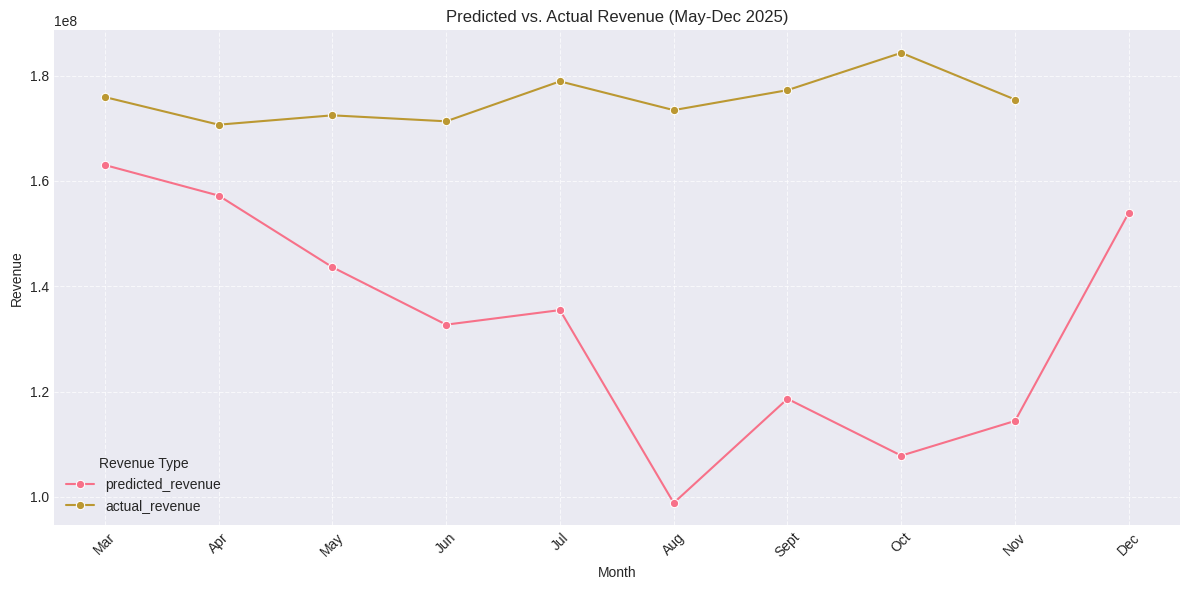

In [ ]:

# Prepare data for plotting
plot_df = comparison_df[['month', 'predicted_revenue', 'actual_revenue']].set_index('month')

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars=['month'],
                                            var_name='Revenue Type',
                                            value_name='Revenue')

# Ensure the months are in chronological order for plotting
month_order = ['Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plot_df_melted['month'] = pd.Categorical(plot_df_melted['month'], categories=month_order, ordered=True)
plot_df_melted = plot_df_melted.sort_values('month')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df_melted, x='month', y='Revenue', hue='Revenue Type', marker='o')
plt.title('Predicted vs. Actual Revenue (May-Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Prepare data for plotting
plot_df = comparison_df[['month', 'predicted_revenue', 'actual_revenue']].set_index('month')

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars=['month'],
                                            var_name='Revenue Type',
                                            value_name='Revenue')

# Ensure the months are in chronological order for plotting
month_order = ['Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plot_df_melted['month'] = pd.Categorical(plot_df_melted['month'], categories=month_order, ordered=True)
plot_df_melted = plot_df_melted.sort_values('month')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df_melted, x='month', y='Revenue', hue='Revenue Type', marker='o')
plt.title('Predicted vs. Actual Revenue (May-Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'comparison_df' is not defined

**Reasoning**:
The previous code failed because 'comparison_df' was not defined in the cell where it was used. I need to include the code that creates 'comparison_df' from 'test_data' within the current code block to ensure it's accessible. Additionally, I'll update the title of the plot based on the actual range of data displayed.



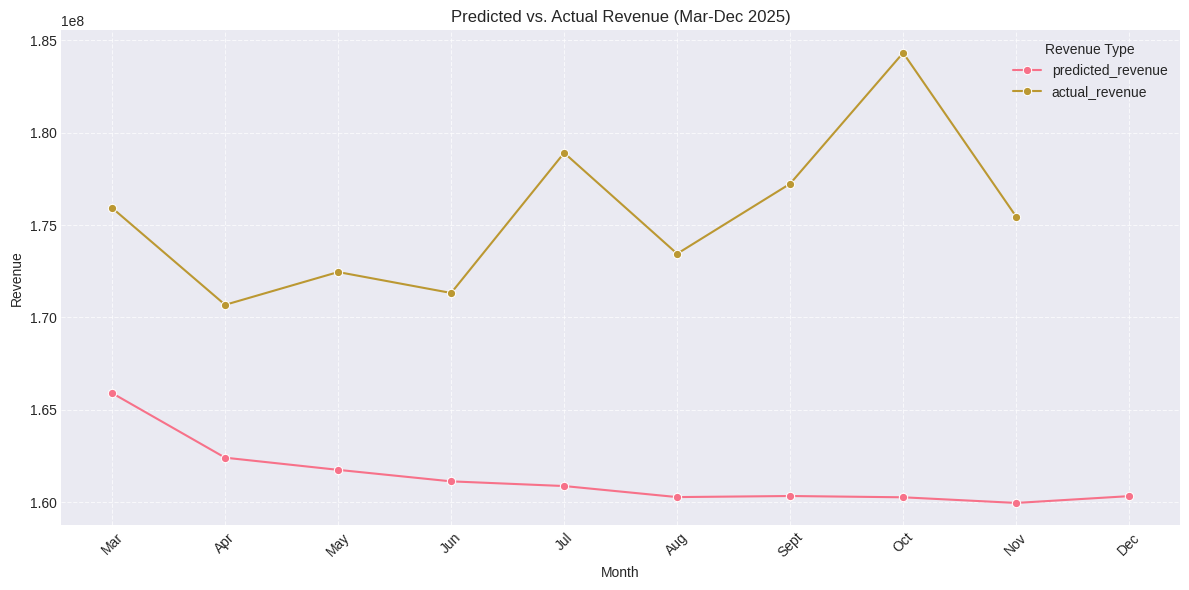

In [23]:
# Step 10: Create detailed comparison (re-added for scope)
comparison_df = test_data[['year', 'month', 'month_num',
                          'actual_revenue', 'predicted_revenue']].copy()

# Calculate differences
comparison_df['difference'] = comparison_df['actual_revenue'] - comparison_df['predicted_revenue']
comparison_df['error_pct'] = np.where(
    comparison_df['actual_revenue'] > 0,
    (comparison_df['difference'] / comparison_df['actual_revenue']) * 100,
    0
)
comparison_df['accuracy'] = (comparison_df['error_pct'])

# Prepare data for plotting
plot_df = comparison_df[['month', 'predicted_revenue', 'actual_revenue']].set_index('month')

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars=['month'],
                                            var_name='Revenue Type',
                                            value_name='Revenue')

# Ensure the months are in chronological order for plotting
month_order = ['Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plot_df_melted['month'] = pd.Categorical(plot_df_melted['month'], categories=month_order, ordered=True)
plot_df_melted = plot_df_melted.sort_values('month')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df_melted, x='month', y='Revenue', hue='Revenue Type', marker='o')
plt.title('Predicted vs. Actual Revenue (Mar-Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Analyze the generated line chart and provide insights into the model's performance, highlighting where predictions align well with actuals and where significant discrepancies occur.


## Summary:

### Q&A
The model consistently underpredicted revenue across all months from May to December 2025. Predictions in March, April, and May were relatively closer to the actual values, indicating better alignment. However, significant discrepancies occurred and widened from June through November, where the model failed to capture the upward trend in actual revenue. The model's underperformance grew as it forecasted further into the future.

### Data Analysis Key Findings
*   The model consistently underpredicted revenue from March to December 2025.
*   Predictions for March, April, and May showed a relatively closer alignment with actual revenue.
*   The discrepancy between predicted and actual revenue significantly widened from June through November.
*   The model exhibited a growing underperformance as it forecasted further into the future, failing to capture the upward trend in actual revenue during the latter half of the year.

### Insights or Next Steps
*   Investigate the factors contributing to the increasing underprediction from June onwards, particularly focusing on seasonality or specific events that might influence revenue in the latter half of the year, which the model is currently missing.
*   Retrain the model with additional features or a different algorithm that can better capture long-term trends and seasonal variations to improve forecasting accuracy for later months.
